In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

from categorical import one_hot_encode_categorical
from feature_nlp import nlp
from feature_numerical import process_numerical_columns
from location_preprocessing import get_locations_features
from feature_date import cyclical_encode_dates
from parse_amenities import parse_amenities

In [24]:
df = pd.read_csv("Airbnb_Data.csv")
print(df.shape)
df.head()

(74111, 29)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [25]:
# Filter out Parking Space and Lighthouse, as they only contain one instance
condition = ~df['property_type'].isin(['Parking Space', 'Lighthouse'])

df = df[condition]
df.shape

(74109, 29)

In [26]:
df.set_index('id', inplace=True)
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [27]:
df_amenities_count = parse_amenities(df)
print(df_amenities_count.shape)
df_amenities_count.head()

(74109, 1)


,amenities_count
id,
6901257,-1.242693
6304928,-0.375426
7919400,0.202751
13418779,-0.375426
3808709,-0.809060


In [28]:
df_categorical = one_hot_encode_categorical(df)
print(df_categorical.shape)
df_categorical.head()

/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(74109, 8)


,property_type,room_type,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable
id,,,,,,,,
6901257,-0.895230,0.084249,-0.442729,-0.038766,1,1,1,0
6304928,-0.895230,0.084249,-0.442729,-0.038766,1,1,0,1
7919400,-0.521275,-0.618749,0.454742,0.709698,1,1,1,1
13418779,-0.008716,0.177020,1.109243,-0.919165,1,1,1,0
3808709,-0.521275,-0.618749,0.454742,0.709698,1,1,1,1


In [29]:
df_categorical.columns

Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
       'instant_bookable'],
      dtype='object')

In [30]:
df_nlp = nlp(df)
print(df_nlp.shape)
df_nlp.head()

(74109, 30)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,amenities_count,keywords_combined,description_polarity,description_subjectivity
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,-1.242693,"brownstone, brooklyn, beautiful, stunning, bridge",0.750000,0.937500
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,-0.375426,"times, place, square, centrally, located",0.297500,0.512083
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.202751,"unit, backyard, lighting, total, entire",0.274085,0.512857
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,-0.375426,"haight, super, away, trendy, street",0.301186,0.553205
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,4,40.0,NaN,20009,0.0,1.0,-0.809060,"tons, metro, diverse, different, columbia",0.239881,0.495833


In [31]:
df_numerical = process_numerical_columns(df)
print(df_numerical.shape)
df_numerical.head()

Filling NAs


/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(

False
(74109, 11)


,accommodates,number_of_reviews,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,host_response_rate_normalized,review_scores_rating,review_scores_rating_normalized
id,,,,,,,,,,,
6901257,3,2,0.500000,1.0,1.0,-0.390190,1.0,94.351967,-1.002064e-15,100.000000,0.059241
6304928,7,6,0.750000,3.0,3.0,1.168009,1.0,100.000000,3.982653e-01,93.000000,0.056532
7919400,5,10,1.500000,3.0,1.0,-0.390190,1.0,100.000000,3.982653e-01,92.000000,0.056129
13418779,4,0,0.666667,2.0,2.0,0.388910,1.0,94.351967,-1.002064e-15,95.252319,0.057425
3808709,2,4,1.000000,1.0,0.0,-1.169290,1.0,100.000000,3.982653e-01,40.000000,0.025236


In [32]:
df_numerical[df_numerical.isna().any(axis=1)]

,accommodates,number_of_reviews,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,host_response_rate_normalized,review_scores_rating,review_scores_rating_normalized
id,,,,,,,,,,,


/Users/ChanWingYiu/opt/miniconda3/lib/python3.10/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.21632368274488525, -0.22401526463951021, -0.27704117297049535, -0.5504049973617441, -0.6606857706718918, -0.29464905443971723, -0.03504170422841744, -0.05259463602601694, -0.03617848617245744, -0.016011843030901172, -0.032233679695850344, -0.012724922514405015, -0.07474199641712549, -0.005194927862790968, -0.09139235070358351, -0.03817476754321505, -0.01722962653384052, -0.020779711451163873, -0.024366371518780607, -0.003673368719554432, -0.032023686061802344, -0.006362461257202507, -0.008213902163345072, -0.025974639313954842, -0.1100785478616123, -0.03181230628601253, -0.007346737439108864, -0.03159951255138711, -0.06319902510277423, -0.012183185759390303, -0.023232423678816613, -0.02264416557288956, -0.03073360770371854, -0.022940180300996718, -0.03887528042313918, -0.01836684359777216, -0.03939249092437684, -0.052337448000

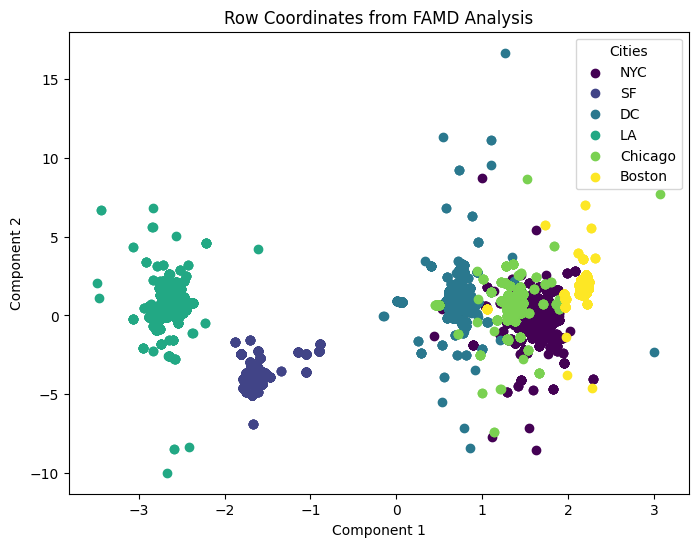

(74109, 3)


,location_component_0,location_component_1,city
id,,,
6901257,1.705741,-0.293946,NYC
6304928,1.660814,-0.233915,NYC
7919400,1.677308,-0.270731,NYC
13418779,-1.683790,-5.062669,SF
3808709,0.756028,0.331737,DC


In [33]:
df_locations  =  get_locations_features(df)
print(df_locations.shape)
df_locations.head()

In [34]:
df_locations.columns

Index(['location_component_0', 'location_component_1', 'city'], dtype='object')

In [35]:
df_datetime = cyclical_encode_dates(df)
print(df_datetime.shape)
df_datetime.head()

Missing rows in first_review: 15862
Missing rows in host_since: 188
Missing rows in last_review: 15825
(74109, 3)


/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users/ChanWingYiu/Documents/Data Science in the Wild/Project/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users/ChanWingYiu

,first_review_days_since,host_since_days_since,last_review_days_since
id,,,
6901257,-0.353750,1.282201,1.166947e+00
6304928,-1.292337,-1.610391,-9.352162e-01
7919400,-1.071894,-1.251655,-8.914211e-01
13418779,0.000000,-0.411577,2.212854e-15
3808709,0.562110,-0.337408,2.521167e-01


In [48]:
df_datetime.columns

Index(['first_review_days_since', 'host_since_days_since',
       'last_review_days_since'],
      dtype='object')

In [49]:
all_data_df = pd.concat([
    df['log_price'],
    df_amenities_count,
    df_categorical[[
        'property_type', 'room_type', 'bed_type', 'cancellation_policy',
        'cleaning_fee', 'host_identity_verified',
        'instant_bookable']],
    df_nlp[['description_polarity', 'description_subjectivity']],
    df_numerical[['accommodates', 'beds_per_bedroom',
                  'bed_and_bathrooms', 'review_scores_rating_normalized', 'number_of_reviews']],
    df_locations[['location_component_0', 'location_component_1', 'city']],
    df_datetime[['first_review_days_since', 'host_since_days_since']]
                         
                         ], axis=1)
print(all_data_df.shape)
all_data_df.head()

(74109, 21)


,log_price,amenities_count,property_type,room_type,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,instant_bookable,description_polarity,...,accommodates,beds_per_bedroom,bed_and_bathrooms,review_scores_rating_normalized,number_of_reviews,location_component_0,location_component_1,city,first_review_days_since,host_since_days_since
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,-1.242693,-0.895230,0.084249,-0.442729,-0.038766,1,1,0,0.750000,...,3,0.500000,-0.390190,0.059241,2,1.705741,-0.293946,NYC,-0.353750,1.282201
6304928,5.129899,-0.375426,-0.895230,0.084249,-0.442729,-0.038766,1,0,1,0.297500,...,7,0.750000,1.168009,0.056532,6,1.660814,-0.233915,NYC,-1.292337,-1.610391
7919400,4.976734,0.202751,-0.521275,-0.618749,0.454742,0.709698,1,1,1,0.274085,...,5,1.500000,-0.390190,0.056129,10,1.677308,-0.270731,NYC,-1.071894,-1.251655
13418779,6.620073,-0.375426,-0.008716,0.177020,1.109243,-0.919165,1,1,0,0.301186,...,4,0.666667,0.388910,0.057425,0,-1.683790,-5.062669,SF,0.000000,-0.411577
3808709,4.744932,-0.809060,-0.521275,-0.618749,0.454742,0.709698,1,1,1,0.239881,...,2,1.000000,-1.169290,0.025236,4,0.756028,0.331737,DC,0.562110,-0.337408


In [50]:
print(all_data_df.dtypes)

log_price                          float64
amenities_count                    float64
property_type                      float64
room_type                          float64
bed_type                           float64
cancellation_policy                float64
cleaning_fee                        object
host_identity_verified              object
instant_bookable                    object
description_polarity               float64
description_subjectivity           float64
accommodates                         int64
beds_per_bedroom                   float64
bed_and_bathrooms                  float64
review_scores_rating_normalized    float64
number_of_reviews                    int64
location_component_0               float64
location_component_1               float64
city                                object
first_review_days_since            float64
host_since_days_since              float64
dtype: object


In [51]:
all_data_df.columns[all_data_df.isna().any()].tolist()

[]

In [52]:
all_data_df.shape

(74109, 21)

In [53]:
X = all_data_df.drop(['log_price', 'city'], axis=1).copy()
X = X.apply(pd.to_numeric)
# Convert boolean columns to integers if there are any
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

y = all_data_df['log_price'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [54]:
model = LinearRegression()

In [55]:
model.fit(X_train, y_train)

LinearRegression()

In [56]:
# Make predictions using the testing set
y_pred = model.predict(X_test)

In [57]:
# The coefficients
# print('Coefficients:', model.coef_)

# Mean squared error
print('Mean squared error:', mean_squared_error(y_test, y_pred))

# Coefficient of determination (1 is perfect prediction)
print('Coefficient of determination:', r2_score(y_test, y_pred))

Mean squared error: 0.24658858041271403
Coefficient of determination: 0.52045450543668


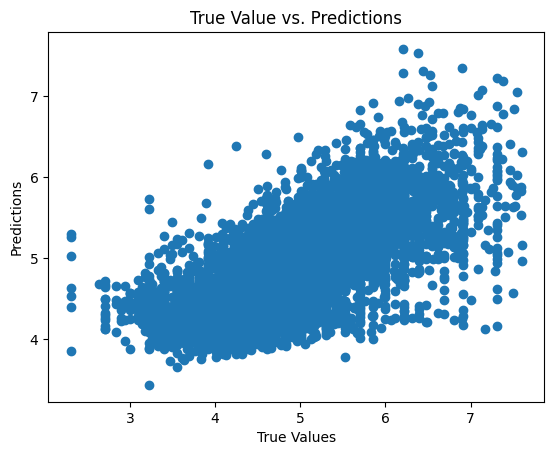

In [58]:
# Plotting for visualization
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Value vs. Predictions')
plt.show()

In [59]:
# Add a constant to the features for the intercept
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y,X_with_const).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     4200.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:27:12   Log-Likelihood:                -53459.
No. Observations:               74109   AIC:                         1.070e+05
Df Residuals:                   74089   BIC:                         1.071e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

# Fitting Linear Regression by City 

city:  Boston
Mean squared error: 0.19125462553892011
Coefficient of determination: 0.5738438867547581


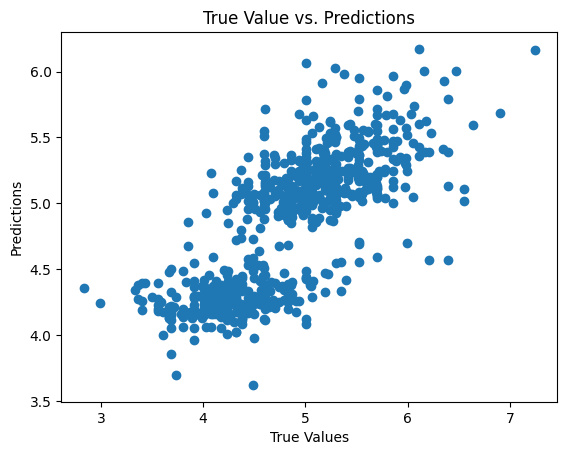

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     230.3
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:41   Log-Likelihood:                -2032.4
No. Observations:                3468   AIC:                             4107.
Df Residuals:                    3447   BIC:                             4236.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

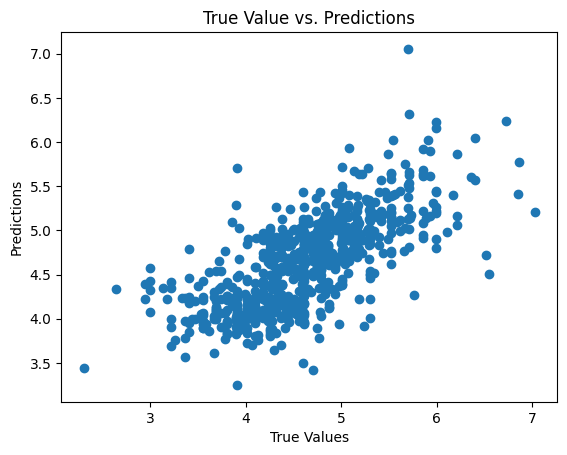

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     221.3
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:42   Log-Likelihood:                -2488.0
No. Observations:                3719   AIC:                             5018.
Df Residuals:                    3698   BIC:                             5149.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

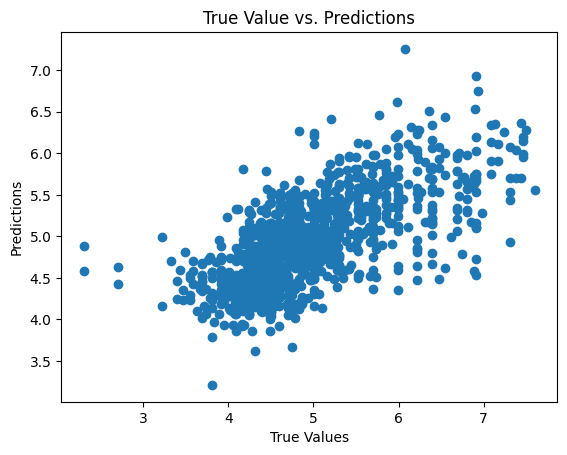

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     213.3
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:42   Log-Likelihood:                -5353.9
No. Observations:                5688   AIC:                         1.075e+04
Df Residuals:                    5667   BIC:                         1.089e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

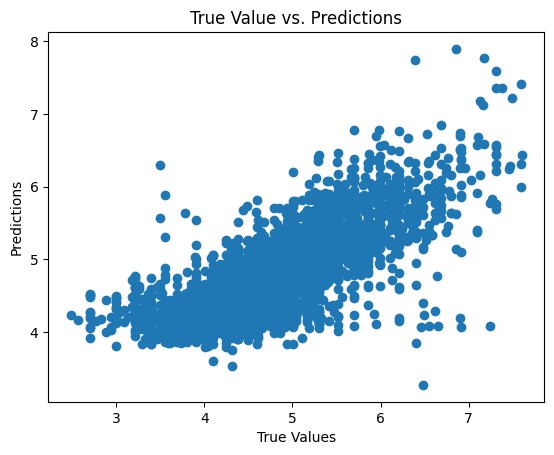

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1537.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:43   Log-Likelihood:                -15386.
No. Observations:               22451   AIC:                         3.081e+04
Df Residuals:                   22430   BIC:                         3.098e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

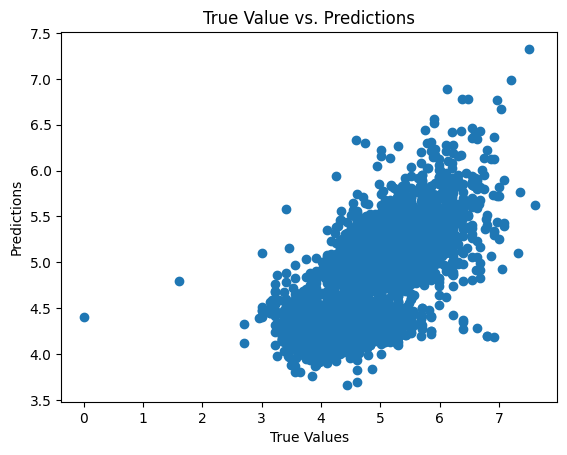

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     1666.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:44   Log-Likelihood:                -21076.
No. Observations:               32349   AIC:                         4.219e+04
Df Residuals:                   32328   BIC:                         4.237e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

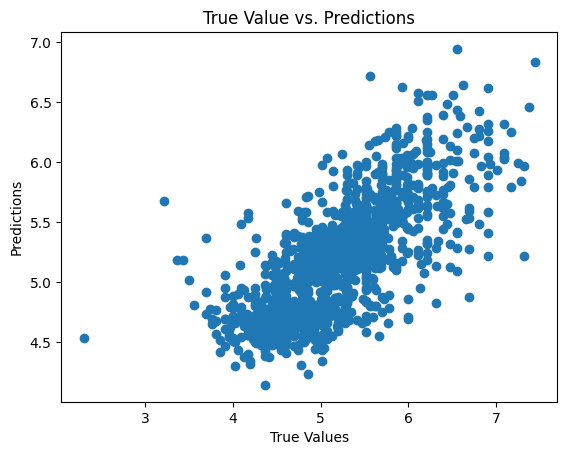

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     364.5
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:45   Log-Likelihood:                -4200.3
No. Observations:                6434   AIC:                             8443.
Df Residuals:                    6413   BIC:                             8585.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [47]:
for city in ['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']:
    print("city: ", city)
    city_df = all_data_df[all_data_df['city'] == city].reset_index(drop=True)
    X = city_df.copy()
    X.drop(['city', 'log_price'], axis=1, inplace=True)
    X = X.apply(pd.to_numeric)
    # Convert boolean columns to integers if there are any
    for col in X.columns:
        if X[col].dtype == bool:
            X[col] = X[col].astype(int)
    y = city_df['log_price']

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Mean squared error
    print('Mean squared error:', mean_squared_error(y_test, y_pred))

    # Coefficient of determination (1 is perfect prediction)
    print('Coefficient of determination:', r2_score(y_test, y_pred))
    # Plotting for visualization
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Value vs. Predictions')
    plt.show()
    # Add a constant to the features for the intercept
    X_with_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_with_const).fit()

    # Print the summary
    print(model.summary())